In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import lsqlin
from scipy import stats
import copy 
from sklearn import svm
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
import tensorflow as tf

In [2]:
vix_df = pd.read_excel( 'VIXfutures_20080414_20201231.xlsx' )

vix_df = vix_df.sort_values( by = ['Date'], ascending = True )

x_df = vix_df[ [ 'Date', 'VIX', 'w', \
                       'CMF30', 'CMF60', 'CMF90', 'CMF120', 'CMF150', \
                       'roll30', 'roll60', 'roll90', 'roll120', 'roll150', \
                       'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9' ] ]

# for eache row, if it contains a non-number element in a column, then drop the entire row
x_df = x_df.dropna()

# for eache row, if it contains a 0 element in a column, then drop the entire row
#x_df = x_df.loc[ ( x_df != 0 ).all( axis = 1 ) ]

# reset the index
x_df= x_df.reset_index( drop = True )

dates = x_df[ 'Date' ]

In [3]:
vix = x_df.VIX 
T = len(vix)

v_1 = x_df.CMF30 
v_2 = x_df.CMF60 
v_3 = x_df.CMF90 
v_4 = x_df.CMF120 
v_5 = x_df.CMF150 

d_theta_log_v_1 = x_df.roll30 
d_theta_log_v_2 = x_df.roll60 
d_theta_log_v_3 = x_df.roll90 
d_theta_log_v_4 = x_df.roll120 
d_theta_log_v_5 = x_df.roll150 

In [4]:
vix_etn_number = 10
x_row = vix_etn_number + 1  #  plus 1 here is for the VIX
x_column = len( v_1 );
X = np.ones( ( x_row, x_column ) )

X[ 0, : ] =  np.log( vix )

X[ 1, : ] =  np.log( v_1 )
X[ 2, : ] =  np.log( v_2 )
X[ 3, : ] =  np.log( v_3 )
X[ 4, : ] =  np.log( v_4 )
X[ 5, : ] =  np.log( v_5 )

X[ 6, : ] = d_theta_log_v_1
X[ 7, : ] = d_theta_log_v_2
X[ 8, : ] = d_theta_log_v_3
X[ 9, : ] = d_theta_log_v_4
X[ 10, : ] = d_theta_log_v_5

In [5]:
#######################################################
####
#### 1-month and 5-month rolling futures portfolios
####
#######################################################

dt = 1/252;
r = .03
vxx = np.zeros(T)
vxz = np.zeros(T)
vxx[0]=100
vxz[0]=100
for t in range(T-1):
    vxx[t+1] = vxx[t]*(1+r*dt + X[ 6, t+1 ]*dt  + (X[ 1, t+1 ]-X[ 1, t ])/X[ 1, t ]  )
    vxz[t+1] = vxz[t]*(1+r*dt + X[ 10, t+1 ]*dt  + (X[ 5, t+1 ]-X[ 5, t ])/X[ 5, t ]  )
    
r_trade = -np.diff(vxx)/vxx[:-1] + 2*np.diff(vxz)/vxz[:-1] 

sign_trade = (np.sign(r_trade)+1)/2  ### sign of returns, to be predicted by classifier

In [6]:
#######################################################
####
#### divide data into training and testing
####
#######################################################

T_train = int(np.round(T/2))

ind_train = np.arange(0,T_train )
X_train = X[:,ind_train]
y_train = sign_trade[ind_train]

ind_test = np.arange(T_train ,T-1)
X_test = X[:,ind_test]
y_test = sign_trade[ind_test]

In [7]:
#######################################################
####
#### build and train deep neural network
####
#######################################################


relu_parameter = 0.1
neuron_num = 1000

activation_function = lambda x: tf.keras.activations.sigmoid( x )  # Sigmoid


model = tf.keras.Sequential( )
model.add( tf.keras.layers.Flatten( input_shape = ( 11, ) ) )
model.add( tf.keras.layers.Dense( neuron_num, activation = activation_function ) )
model.add( tf.keras.layers.Dense( neuron_num, activation = activation_function ) )
model.add( tf.keras.layers.Dense( neuron_num, activation = activation_function ) )
model.add( tf.keras.layers.Dense( neuron_num, activation = activation_function ) )
#model.add( tf.keras.layers.Dense( neuron_num, activation = activation_function ) )
#model.add( tf.keras.layers.Dense( neuron_num, activation = activation_function ) )
model.add( tf.keras.layers.Dense( 1, activation = 'sigmoid'  ) )

model.compile( loss = 'binary_crossentropy', optimizer = 'adam',\
              metrics = [ 'accuracy', 'mean_absolute_error' ] )


num_epoch = 2000
model_history = model.fit( X_train.T, y_train, \
                  epochs = num_epoch, batch_size = 512, shuffle = True, validation_split = 0.2 )


Epoch 1/2000
3/3 [==============================] - 0s 103ms/step - loss: 1.5067 - accuracy: 0.5211 - mean_absolute_error: 0.4405 - val_loss: 0.6945 - val_accuracy: 0.4860 - val_mean_absolute_error: 0.5004
Epoch 2/2000
3/3 [==============================] - 0s 55ms/step - loss: 0.9785 - accuracy: 0.3914 - mean_absolute_error: 0.5453 - val_loss: 0.7042 - val_accuracy: 0.4860 - val_mean_absolute_error: 0.5017
Epoch 3/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.7097 - accuracy: 0.5383 - mean_absolute_error: 0.4730 - val_loss: 0.9801 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4905
Epoch 4/2000
3/3 [==============================] - 0s 61ms/step - loss: 0.8031 - accuracy: 0.6086 - mean_absolute_error: 0.4287 - val_loss: 0.7973 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4936
Epoch 5/2000
3/3 [==============================] - 0s 55ms/step - loss: 0.6834 - accuracy: 0.6086 - mean_absolute_error: 0.4621 - val_loss: 0.6931 - val_accuracy: 0.5140 - val_me

Epoch 41/2000
3/3 [==============================] - 0s 44ms/step - loss: 0.6697 - accuracy: 0.6086 - mean_absolute_error: 0.4748 - val_loss: 0.7105 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4970
Epoch 42/2000
3/3 [==============================] - 0s 46ms/step - loss: 0.6694 - accuracy: 0.6086 - mean_absolute_error: 0.4770 - val_loss: 0.7094 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4971
Epoch 43/2000
3/3 [==============================] - 0s 45ms/step - loss: 0.6695 - accuracy: 0.6086 - mean_absolute_error: 0.4773 - val_loss: 0.7115 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4969
Epoch 44/2000
3/3 [==============================] - 0s 43ms/step - loss: 0.6695 - accuracy: 0.6086 - mean_absolute_error: 0.4754 - val_loss: 0.7158 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4966
Epoch 45/2000
3/3 [==============================] - 0s 45ms/step - loss: 0.6697 - accuracy: 0.6086 - mean_absolute_error: 0.4742 - val_loss: 0.7132 - val_accuracy: 0.5140 - va

Epoch 81/2000
3/3 [==============================] - 0s 46ms/step - loss: 0.6697 - accuracy: 0.6086 - mean_absolute_error: 0.4744 - val_loss: 0.7121 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4969
Epoch 82/2000
3/3 [==============================] - 0s 48ms/step - loss: 0.6704 - accuracy: 0.6086 - mean_absolute_error: 0.4783 - val_loss: 0.7052 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4974
Epoch 83/2000
3/3 [==============================] - 0s 46ms/step - loss: 0.6696 - accuracy: 0.6086 - mean_absolute_error: 0.4787 - val_loss: 0.7140 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4968
Epoch 84/2000
3/3 [==============================] - 0s 45ms/step - loss: 0.6697 - accuracy: 0.6086 - mean_absolute_error: 0.4737 - val_loss: 0.7197 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4964
Epoch 85/2000
3/3 [==============================] - 0s 46ms/step - loss: 0.6700 - accuracy: 0.6086 - mean_absolute_error: 0.4732 - val_loss: 0.7121 - val_accuracy: 0.5140 - va

Epoch 121/2000
3/3 [==============================] - 0s 66ms/step - loss: 0.6691 - accuracy: 0.6086 - mean_absolute_error: 0.4759 - val_loss: 0.7097 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4970
Epoch 122/2000
3/3 [==============================] - 0s 50ms/step - loss: 0.6692 - accuracy: 0.6086 - mean_absolute_error: 0.4768 - val_loss: 0.7096 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4970
Epoch 123/2000
3/3 [==============================] - 0s 48ms/step - loss: 0.6694 - accuracy: 0.6086 - mean_absolute_error: 0.4765 - val_loss: 0.7099 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4970
Epoch 124/2000
3/3 [==============================] - 0s 45ms/step - loss: 0.6695 - accuracy: 0.6086 - mean_absolute_error: 0.4766 - val_loss: 0.7061 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4973
Epoch 125/2000
3/3 [==============================] - 0s 50ms/step - loss: 0.6704 - accuracy: 0.6086 - mean_absolute_error: 0.4812 - val_loss: 0.7017 - val_accuracy: 0.5140

Epoch 200/2000
3/3 [==============================] - 0s 47ms/step - loss: 0.6123 - accuracy: 0.6742 - mean_absolute_error: 0.4202 - val_loss: 0.6956 - val_accuracy: 0.5452 - val_mean_absolute_error: 0.4893
Epoch 201/2000
3/3 [==============================] - 0s 45ms/step - loss: 0.6140 - accuracy: 0.6758 - mean_absolute_error: 0.4271 - val_loss: 0.6958 - val_accuracy: 0.5452 - val_mean_absolute_error: 0.4892
Epoch 202/2000
3/3 [==============================] - 0s 50ms/step - loss: 0.6119 - accuracy: 0.6758 - mean_absolute_error: 0.4238 - val_loss: 0.6928 - val_accuracy: 0.5763 - val_mean_absolute_error: 0.4879
Epoch 203/2000
3/3 [==============================] - 0s 50ms/step - loss: 0.6115 - accuracy: 0.6719 - mean_absolute_error: 0.4225 - val_loss: 0.6939 - val_accuracy: 0.5794 - val_mean_absolute_error: 0.4883
Epoch 204/2000
3/3 [==============================] - 0s 55ms/step - loss: 0.6115 - accuracy: 0.6727 - mean_absolute_error: 0.4234 - val_loss: 0.6937 - val_accuracy: 0.5826

Epoch 279/2000
3/3 [==============================] - 0s 50ms/step - loss: 0.6114 - accuracy: 0.6695 - mean_absolute_error: 0.4179 - val_loss: 0.6933 - val_accuracy: 0.5732 - val_mean_absolute_error: 0.4875
Epoch 280/2000
3/3 [==============================] - 0s 46ms/step - loss: 0.6128 - accuracy: 0.6711 - mean_absolute_error: 0.4251 - val_loss: 0.6952 - val_accuracy: 0.5732 - val_mean_absolute_error: 0.4886
Epoch 281/2000
3/3 [==============================] - 0s 48ms/step - loss: 0.6148 - accuracy: 0.6750 - mean_absolute_error: 0.4190 - val_loss: 0.6939 - val_accuracy: 0.5514 - val_mean_absolute_error: 0.4868
Epoch 282/2000
3/3 [==============================] - 0s 46ms/step - loss: 0.6164 - accuracy: 0.6664 - mean_absolute_error: 0.4261 - val_loss: 0.6971 - val_accuracy: 0.5607 - val_mean_absolute_error: 0.4893
Epoch 283/2000
3/3 [==============================] - 0s 48ms/step - loss: 0.6107 - accuracy: 0.6781 - mean_absolute_error: 0.4222 - val_loss: 0.6992 - val_accuracy: 0.5171

Epoch 358/2000
3/3 [==============================] - 0s 50ms/step - loss: 0.6216 - accuracy: 0.6687 - mean_absolute_error: 0.4156 - val_loss: 0.6943 - val_accuracy: 0.5389 - val_mean_absolute_error: 0.4874
Epoch 359/2000
3/3 [==============================] - 0s 50ms/step - loss: 0.6137 - accuracy: 0.6812 - mean_absolute_error: 0.4273 - val_loss: 0.6984 - val_accuracy: 0.5421 - val_mean_absolute_error: 0.4901
Epoch 360/2000
3/3 [==============================] - 0s 48ms/step - loss: 0.6134 - accuracy: 0.6766 - mean_absolute_error: 0.4258 - val_loss: 0.6979 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4862
Epoch 361/2000
3/3 [==============================] - 0s 51ms/step - loss: 0.6126 - accuracy: 0.6641 - mean_absolute_error: 0.4160 - val_loss: 0.6931 - val_accuracy: 0.5857 - val_mean_absolute_error: 0.4884
Epoch 362/2000
3/3 [==============================] - 0s 47ms/step - loss: 0.6115 - accuracy: 0.6859 - mean_absolute_error: 0.4245 - val_loss: 0.6939 - val_accuracy: 0.5576

Epoch 437/2000
3/3 [==============================] - 0s 53ms/step - loss: 0.6089 - accuracy: 0.6820 - mean_absolute_error: 0.4204 - val_loss: 0.6930 - val_accuracy: 0.5701 - val_mean_absolute_error: 0.4869
Epoch 438/2000
3/3 [==============================] - 0s 50ms/step - loss: 0.6091 - accuracy: 0.6812 - mean_absolute_error: 0.4202 - val_loss: 0.6937 - val_accuracy: 0.5670 - val_mean_absolute_error: 0.4867
Epoch 439/2000
3/3 [==============================] - 0s 47ms/step - loss: 0.6122 - accuracy: 0.6711 - mean_absolute_error: 0.4163 - val_loss: 0.6949 - val_accuracy: 0.5545 - val_mean_absolute_error: 0.4862
Epoch 440/2000
3/3 [==============================] - 0s 65ms/step - loss: 0.6079 - accuracy: 0.6859 - mean_absolute_error: 0.4193 - val_loss: 0.6974 - val_accuracy: 0.5732 - val_mean_absolute_error: 0.4881
Epoch 441/2000
3/3 [==============================] - 0s 65ms/step - loss: 0.6102 - accuracy: 0.6828 - mean_absolute_error: 0.4244 - val_loss: 0.6957 - val_accuracy: 0.5483

Epoch 516/2000
3/3 [==============================] - 0s 91ms/step - loss: 0.6074 - accuracy: 0.6773 - mean_absolute_error: 0.4167 - val_loss: 0.6938 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4866
Epoch 517/2000
3/3 [==============================] - 0s 88ms/step - loss: 0.6064 - accuracy: 0.6797 - mean_absolute_error: 0.4185 - val_loss: 0.6948 - val_accuracy: 0.5701 - val_mean_absolute_error: 0.4884
Epoch 518/2000
3/3 [==============================] - 0s 50ms/step - loss: 0.6067 - accuracy: 0.6820 - mean_absolute_error: 0.4210 - val_loss: 0.6939 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4865
Epoch 519/2000
3/3 [==============================] - 0s 115ms/step - loss: 0.6069 - accuracy: 0.6719 - mean_absolute_error: 0.4159 - val_loss: 0.6918 - val_accuracy: 0.5576 - val_mean_absolute_error: 0.4873
Epoch 520/2000
3/3 [==============================] - 0s 96ms/step - loss: 0.6058 - accuracy: 0.6805 - mean_absolute_error: 0.4185 - val_loss: 0.6942 - val_accuracy: 0.588

Epoch 595/2000
3/3 [==============================] - 0s 50ms/step - loss: 0.6038 - accuracy: 0.6797 - mean_absolute_error: 0.4201 - val_loss: 0.6954 - val_accuracy: 0.5452 - val_mean_absolute_error: 0.4861
Epoch 596/2000
3/3 [==============================] - 0s 50ms/step - loss: 0.6009 - accuracy: 0.6758 - mean_absolute_error: 0.4126 - val_loss: 0.6982 - val_accuracy: 0.5202 - val_mean_absolute_error: 0.4852
Epoch 597/2000
3/3 [==============================] - 0s 49ms/step - loss: 0.6042 - accuracy: 0.6719 - mean_absolute_error: 0.4100 - val_loss: 0.6950 - val_accuracy: 0.5483 - val_mean_absolute_error: 0.4877
Epoch 598/2000
3/3 [==============================] - 0s 49ms/step - loss: 0.6015 - accuracy: 0.6797 - mean_absolute_error: 0.4174 - val_loss: 0.6951 - val_accuracy: 0.5514 - val_mean_absolute_error: 0.4879
Epoch 599/2000
3/3 [==============================] - 0s 50ms/step - loss: 0.6024 - accuracy: 0.6781 - mean_absolute_error: 0.4141 - val_loss: 0.6951 - val_accuracy: 0.5483

Epoch 674/2000
3/3 [==============================] - 0s 50ms/step - loss: 0.5980 - accuracy: 0.6812 - mean_absolute_error: 0.4076 - val_loss: 0.6993 - val_accuracy: 0.5234 - val_mean_absolute_error: 0.4844
Epoch 675/2000
3/3 [==============================] - 0s 50ms/step - loss: 0.5982 - accuracy: 0.6687 - mean_absolute_error: 0.4125 - val_loss: 0.7011 - val_accuracy: 0.5639 - val_mean_absolute_error: 0.4880
Epoch 676/2000
3/3 [==============================] - 0s 51ms/step - loss: 0.5986 - accuracy: 0.6766 - mean_absolute_error: 0.4138 - val_loss: 0.6957 - val_accuracy: 0.5016 - val_mean_absolute_error: 0.4867
Epoch 677/2000
3/3 [==============================] - 0s 50ms/step - loss: 0.5995 - accuracy: 0.6727 - mean_absolute_error: 0.4136 - val_loss: 0.7019 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4888
Epoch 678/2000
3/3 [==============================] - 0s 50ms/step - loss: 0.5957 - accuracy: 0.6812 - mean_absolute_error: 0.4088 - val_loss: 0.7046 - val_accuracy: 0.5047

Epoch 753/2000
3/3 [==============================] - 0s 50ms/step - loss: 0.5915 - accuracy: 0.6773 - mean_absolute_error: 0.4049 - val_loss: 0.7115 - val_accuracy: 0.5576 - val_mean_absolute_error: 0.4911
Epoch 754/2000
3/3 [==============================] - 0s 50ms/step - loss: 0.5978 - accuracy: 0.6852 - mean_absolute_error: 0.4164 - val_loss: 0.7068 - val_accuracy: 0.4953 - val_mean_absolute_error: 0.4868
Epoch 755/2000
3/3 [==============================] - 0s 56ms/step - loss: 0.5924 - accuracy: 0.6875 - mean_absolute_error: 0.4028 - val_loss: 0.7036 - val_accuracy: 0.4984 - val_mean_absolute_error: 0.4873
Epoch 756/2000
3/3 [==============================] - 0s 50ms/step - loss: 0.5918 - accuracy: 0.6844 - mean_absolute_error: 0.4079 - val_loss: 0.7088 - val_accuracy: 0.5109 - val_mean_absolute_error: 0.4885
Epoch 757/2000
3/3 [==============================] - 0s 50ms/step - loss: 0.5915 - accuracy: 0.6867 - mean_absolute_error: 0.4063 - val_loss: 0.7116 - val_accuracy: 0.4984

Epoch 832/2000
3/3 [==============================] - 0s 45ms/step - loss: 0.5829 - accuracy: 0.6969 - mean_absolute_error: 0.4056 - val_loss: 0.7048 - val_accuracy: 0.5078 - val_mean_absolute_error: 0.4823
Epoch 833/2000
3/3 [==============================] - 0s 58ms/step - loss: 0.5833 - accuracy: 0.7023 - mean_absolute_error: 0.3933 - val_loss: 0.7155 - val_accuracy: 0.5047 - val_mean_absolute_error: 0.4870
Epoch 834/2000
3/3 [==============================] - 0s 59ms/step - loss: 0.5908 - accuracy: 0.6773 - mean_absolute_error: 0.4055 - val_loss: 0.7076 - val_accuracy: 0.4922 - val_mean_absolute_error: 0.4843
Epoch 835/2000
3/3 [==============================] - 0s 64ms/step - loss: 0.5841 - accuracy: 0.7008 - mean_absolute_error: 0.3931 - val_loss: 0.7033 - val_accuracy: 0.5171 - val_mean_absolute_error: 0.4800
Epoch 836/2000
3/3 [==============================] - 0s 50ms/step - loss: 0.5861 - accuracy: 0.6883 - mean_absolute_error: 0.3991 - val_loss: 0.7088 - val_accuracy: 0.5639

Epoch 911/2000
3/3 [==============================] - 0s 52ms/step - loss: 0.5663 - accuracy: 0.7133 - mean_absolute_error: 0.3931 - val_loss: 0.7131 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4895
Epoch 912/2000
3/3 [==============================] - 0s 55ms/step - loss: 0.5688 - accuracy: 0.7109 - mean_absolute_error: 0.3905 - val_loss: 0.7048 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4821
Epoch 913/2000
3/3 [==============================] - 0s 50ms/step - loss: 0.5644 - accuracy: 0.7133 - mean_absolute_error: 0.3870 - val_loss: 0.7124 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4812
Epoch 914/2000
3/3 [==============================] - 0s 55ms/step - loss: 0.5700 - accuracy: 0.7023 - mean_absolute_error: 0.3922 - val_loss: 0.7222 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4789
Epoch 915/2000
3/3 [==============================] - 0s 55ms/step - loss: 0.5661 - accuracy: 0.7086 - mean_absolute_error: 0.3791 - val_loss: 0.7133 - val_accuracy: 0.5358

Epoch 990/2000
3/3 [==============================] - 0s 52ms/step - loss: 0.5481 - accuracy: 0.7242 - mean_absolute_error: 0.3781 - val_loss: 0.7265 - val_accuracy: 0.5483 - val_mean_absolute_error: 0.4788
Epoch 991/2000
3/3 [==============================] - 0s 51ms/step - loss: 0.5508 - accuracy: 0.7203 - mean_absolute_error: 0.3737 - val_loss: 0.7300 - val_accuracy: 0.5421 - val_mean_absolute_error: 0.4807
Epoch 992/2000
3/3 [==============================] - 0s 47ms/step - loss: 0.5458 - accuracy: 0.7250 - mean_absolute_error: 0.3694 - val_loss: 0.7438 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4858
Epoch 993/2000
3/3 [==============================] - 0s 45ms/step - loss: 0.5475 - accuracy: 0.7219 - mean_absolute_error: 0.3749 - val_loss: 0.7273 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4820
Epoch 994/2000
3/3 [==============================] - 0s 45ms/step - loss: 0.5535 - accuracy: 0.7195 - mean_absolute_error: 0.3881 - val_loss: 0.7338 - val_accuracy: 0.5421

3/3 [==============================] - 0s 81ms/step - loss: 0.5339 - accuracy: 0.7328 - mean_absolute_error: 0.3621 - val_loss: 0.7473 - val_accuracy: 0.5639 - val_mean_absolute_error: 0.4856
Epoch 1069/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.5415 - accuracy: 0.7203 - mean_absolute_error: 0.3776 - val_loss: 0.7548 - val_accuracy: 0.5452 - val_mean_absolute_error: 0.4823
Epoch 1070/2000
3/3 [==============================] - 0s 82ms/step - loss: 0.5282 - accuracy: 0.7398 - mean_absolute_error: 0.3519 - val_loss: 0.7532 - val_accuracy: 0.5483 - val_mean_absolute_error: 0.4758
Epoch 1071/2000
3/3 [==============================] - 0s 56ms/step - loss: 0.5279 - accuracy: 0.7406 - mean_absolute_error: 0.3616 - val_loss: 0.7583 - val_accuracy: 0.5794 - val_mean_absolute_error: 0.4821
Epoch 1072/2000
3/3 [==============================] - 0s 46ms/step - loss: 0.5244 - accuracy: 0.7383 - mean_absolute_error: 0.3574 - val_loss: 0.7593 - val_accuracy: 0.5358 - val_mean

3/3 [==============================] - 0s 47ms/step - loss: 0.4962 - accuracy: 0.7594 - mean_absolute_error: 0.3396 - val_loss: 0.7840 - val_accuracy: 0.5607 - val_mean_absolute_error: 0.4769
Epoch 1147/2000
3/3 [==============================] - 0s 81ms/step - loss: 0.4923 - accuracy: 0.7617 - mean_absolute_error: 0.3424 - val_loss: 0.7881 - val_accuracy: 0.5576 - val_mean_absolute_error: 0.4745
Epoch 1148/2000
3/3 [==============================] - 0s 50ms/step - loss: 0.4946 - accuracy: 0.7617 - mean_absolute_error: 0.3419 - val_loss: 0.8000 - val_accuracy: 0.5639 - val_mean_absolute_error: 0.4756
Epoch 1149/2000
3/3 [==============================] - 0s 47ms/step - loss: 0.4938 - accuracy: 0.7516 - mean_absolute_error: 0.3315 - val_loss: 0.8028 - val_accuracy: 0.5732 - val_mean_absolute_error: 0.4799
Epoch 1150/2000
3/3 [==============================] - 0s 46ms/step - loss: 0.4894 - accuracy: 0.7617 - mean_absolute_error: 0.3342 - val_loss: 0.7870 - val_accuracy: 0.5545 - val_mean

3/3 [==============================] - 0s 68ms/step - loss: 0.4630 - accuracy: 0.7773 - mean_absolute_error: 0.3171 - val_loss: 0.8684 - val_accuracy: 0.5483 - val_mean_absolute_error: 0.4788
Epoch 1225/2000
3/3 [==============================] - 0s 65ms/step - loss: 0.4621 - accuracy: 0.7875 - mean_absolute_error: 0.3156 - val_loss: 0.8650 - val_accuracy: 0.5421 - val_mean_absolute_error: 0.4801
Epoch 1226/2000
3/3 [==============================] - 0s 58ms/step - loss: 0.4629 - accuracy: 0.7836 - mean_absolute_error: 0.3115 - val_loss: 0.8645 - val_accuracy: 0.5452 - val_mean_absolute_error: 0.4822
Epoch 1227/2000
3/3 [==============================] - 0s 65ms/step - loss: 0.4655 - accuracy: 0.7766 - mean_absolute_error: 0.3231 - val_loss: 0.8614 - val_accuracy: 0.5452 - val_mean_absolute_error: 0.4813
Epoch 1228/2000
3/3 [==============================] - 0s 61ms/step - loss: 0.4620 - accuracy: 0.7883 - mean_absolute_error: 0.3115 - val_loss: 0.8790 - val_accuracy: 0.5452 - val_mean

3/3 [==============================] - 0s 48ms/step - loss: 0.4407 - accuracy: 0.7898 - mean_absolute_error: 0.3033 - val_loss: 0.9332 - val_accuracy: 0.5639 - val_mean_absolute_error: 0.4746
Epoch 1303/2000
3/3 [==============================] - 0s 49ms/step - loss: 0.4353 - accuracy: 0.7992 - mean_absolute_error: 0.3008 - val_loss: 0.9657 - val_accuracy: 0.5452 - val_mean_absolute_error: 0.4835
Epoch 1304/2000
3/3 [==============================] - 0s 56ms/step - loss: 0.4337 - accuracy: 0.8016 - mean_absolute_error: 0.2955 - val_loss: 0.9404 - val_accuracy: 0.5514 - val_mean_absolute_error: 0.4771
Epoch 1305/2000
3/3 [==============================] - 0s 117ms/step - loss: 0.4311 - accuracy: 0.8016 - mean_absolute_error: 0.2933 - val_loss: 0.9545 - val_accuracy: 0.5421 - val_mean_absolute_error: 0.4841
Epoch 1306/2000
3/3 [==============================] - 0s 68ms/step - loss: 0.4311 - accuracy: 0.8023 - mean_absolute_error: 0.2972 - val_loss: 0.9511 - val_accuracy: 0.5421 - val_mea

3/3 [==============================] - 0s 67ms/step - loss: 0.3990 - accuracy: 0.8203 - mean_absolute_error: 0.2770 - val_loss: 1.0539 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4808
Epoch 1381/2000
3/3 [==============================] - 0s 57ms/step - loss: 0.3962 - accuracy: 0.8219 - mean_absolute_error: 0.2693 - val_loss: 1.0729 - val_accuracy: 0.5202 - val_mean_absolute_error: 0.4920
Epoch 1382/2000
3/3 [==============================] - 0s 79ms/step - loss: 0.4034 - accuracy: 0.8211 - mean_absolute_error: 0.2849 - val_loss: 1.0498 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4789
Epoch 1383/2000
3/3 [==============================] - 0s 53ms/step - loss: 0.3994 - accuracy: 0.8234 - mean_absolute_error: 0.2641 - val_loss: 1.0625 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4866
Epoch 1384/2000
3/3 [==============================] - 0s 59ms/step - loss: 0.3929 - accuracy: 0.8273 - mean_absolute_error: 0.2722 - val_loss: 1.0360 - val_accuracy: 0.5109 - val_mean

3/3 [==============================] - 0s 62ms/step - loss: 0.3802 - accuracy: 0.8148 - mean_absolute_error: 0.2600 - val_loss: 1.2047 - val_accuracy: 0.5202 - val_mean_absolute_error: 0.4935
Epoch 1459/2000
3/3 [==============================] - 0s 67ms/step - loss: 0.3665 - accuracy: 0.8352 - mean_absolute_error: 0.2451 - val_loss: 1.1889 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4921
Epoch 1460/2000
3/3 [==============================] - 0s 75ms/step - loss: 0.3668 - accuracy: 0.8359 - mean_absolute_error: 0.2560 - val_loss: 1.1608 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4768
Epoch 1461/2000
3/3 [==============================] - 0s 80ms/step - loss: 0.3690 - accuracy: 0.8391 - mean_absolute_error: 0.2482 - val_loss: 1.2048 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4841
Epoch 1462/2000
3/3 [==============================] - 0s 77ms/step - loss: 0.3704 - accuracy: 0.8320 - mean_absolute_error: 0.2517 - val_loss: 1.1878 - val_accuracy: 0.5389 - val_mean

3/3 [==============================] - 0s 76ms/step - loss: 0.3522 - accuracy: 0.8336 - mean_absolute_error: 0.2427 - val_loss: 1.2350 - val_accuracy: 0.5389 - val_mean_absolute_error: 0.4697
Epoch 1537/2000
3/3 [==============================] - 0s 68ms/step - loss: 0.3760 - accuracy: 0.8336 - mean_absolute_error: 0.2288 - val_loss: 1.3574 - val_accuracy: 0.4860 - val_mean_absolute_error: 0.5077
Epoch 1538/2000
3/3 [==============================] - 0s 68ms/step - loss: 0.3676 - accuracy: 0.8289 - mean_absolute_error: 0.2497 - val_loss: 1.2731 - val_accuracy: 0.5514 - val_mean_absolute_error: 0.4821
Epoch 1539/2000
3/3 [==============================] - 0s 70ms/step - loss: 0.3759 - accuracy: 0.8297 - mean_absolute_error: 0.2285 - val_loss: 1.3963 - val_accuracy: 0.4953 - val_mean_absolute_error: 0.5006
Epoch 1540/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.3675 - accuracy: 0.8313 - mean_absolute_error: 0.2477 - val_loss: 1.2410 - val_accuracy: 0.5296 - val_mean

3/3 [==============================] - 0s 59ms/step - loss: 0.3003 - accuracy: 0.8703 - mean_absolute_error: 0.1943 - val_loss: 1.4420 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.5020
Epoch 1615/2000
3/3 [==============================] - 0s 67ms/step - loss: 0.3010 - accuracy: 0.8703 - mean_absolute_error: 0.2071 - val_loss: 1.3771 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4823
Epoch 1616/2000
3/3 [==============================] - 0s 52ms/step - loss: 0.3026 - accuracy: 0.8703 - mean_absolute_error: 0.1963 - val_loss: 1.4542 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4921
Epoch 1617/2000
3/3 [==============================] - 0s 50ms/step - loss: 0.3001 - accuracy: 0.8680 - mean_absolute_error: 0.2080 - val_loss: 1.3858 - val_accuracy: 0.5234 - val_mean_absolute_error: 0.4904
Epoch 1618/2000
3/3 [==============================] - 0s 53ms/step - loss: 0.3016 - accuracy: 0.8648 - mean_absolute_error: 0.1999 - val_loss: 1.4775 - val_accuracy: 0.5171 - val_mean

3/3 [==============================] - 0s 83ms/step - loss: 0.2728 - accuracy: 0.8813 - mean_absolute_error: 0.1897 - val_loss: 1.5028 - val_accuracy: 0.5421 - val_mean_absolute_error: 0.4838
Epoch 1693/2000
3/3 [==============================] - 0s 86ms/step - loss: 0.2722 - accuracy: 0.8750 - mean_absolute_error: 0.1847 - val_loss: 1.5312 - val_accuracy: 0.5202 - val_mean_absolute_error: 0.4900
Epoch 1694/2000
3/3 [==============================] - 0s 82ms/step - loss: 0.2678 - accuracy: 0.8898 - mean_absolute_error: 0.1851 - val_loss: 1.5017 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4834
Epoch 1695/2000
3/3 [==============================] - 0s 51ms/step - loss: 0.2708 - accuracy: 0.8820 - mean_absolute_error: 0.1834 - val_loss: 1.5177 - val_accuracy: 0.5202 - val_mean_absolute_error: 0.4897
Epoch 1696/2000
3/3 [==============================] - 0s 52ms/step - loss: 0.2659 - accuracy: 0.8859 - mean_absolute_error: 0.1837 - val_loss: 1.4991 - val_accuracy: 0.5234 - val_mean

3/3 [==============================] - 0s 70ms/step - loss: 0.2455 - accuracy: 0.8992 - mean_absolute_error: 0.1747 - val_loss: 1.6229 - val_accuracy: 0.5171 - val_mean_absolute_error: 0.4889
Epoch 1771/2000
3/3 [==============================] - 0s 55ms/step - loss: 0.2475 - accuracy: 0.8945 - mean_absolute_error: 0.1621 - val_loss: 1.5982 - val_accuracy: 0.5171 - val_mean_absolute_error: 0.4808
Epoch 1772/2000
3/3 [==============================] - 0s 49ms/step - loss: 0.2435 - accuracy: 0.8883 - mean_absolute_error: 0.1734 - val_loss: 1.6027 - val_accuracy: 0.5140 - val_mean_absolute_error: 0.4898
Epoch 1773/2000
3/3 [==============================] - 0s 48ms/step - loss: 0.2539 - accuracy: 0.8891 - mean_absolute_error: 0.1703 - val_loss: 1.6302 - val_accuracy: 0.5358 - val_mean_absolute_error: 0.4838
Epoch 1774/2000
3/3 [==============================] - 0s 49ms/step - loss: 0.2469 - accuracy: 0.8930 - mean_absolute_error: 0.1689 - val_loss: 1.6065 - val_accuracy: 0.5327 - val_mean

3/3 [==============================] - 0s 92ms/step - loss: 0.2232 - accuracy: 0.9062 - mean_absolute_error: 0.1581 - val_loss: 1.7619 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4828
Epoch 1849/2000
3/3 [==============================] - 0s 69ms/step - loss: 0.2207 - accuracy: 0.9008 - mean_absolute_error: 0.1514 - val_loss: 1.7505 - val_accuracy: 0.5234 - val_mean_absolute_error: 0.4784
Epoch 1850/2000
3/3 [==============================] - 0s 114ms/step - loss: 0.2151 - accuracy: 0.9070 - mean_absolute_error: 0.1511 - val_loss: 1.8063 - val_accuracy: 0.5389 - val_mean_absolute_error: 0.4844
Epoch 1851/2000
3/3 [==============================] - 0s 75ms/step - loss: 0.2146 - accuracy: 0.9156 - mean_absolute_error: 0.1515 - val_loss: 1.8265 - val_accuracy: 0.5327 - val_mean_absolute_error: 0.4852
Epoch 1852/2000
3/3 [==============================] - 0s 59ms/step - loss: 0.2179 - accuracy: 0.9086 - mean_absolute_error: 0.1496 - val_loss: 1.8194 - val_accuracy: 0.5296 - val_mea

3/3 [==============================] - 0s 107ms/step - loss: 0.1990 - accuracy: 0.9195 - mean_absolute_error: 0.1378 - val_loss: 1.8935 - val_accuracy: 0.5265 - val_mean_absolute_error: 0.4771
Epoch 1927/2000
3/3 [==============================] - 0s 76ms/step - loss: 0.1949 - accuracy: 0.9180 - mean_absolute_error: 0.1359 - val_loss: 1.9484 - val_accuracy: 0.5234 - val_mean_absolute_error: 0.4890
Epoch 1928/2000
3/3 [==============================] - 0s 73ms/step - loss: 0.2098 - accuracy: 0.9125 - mean_absolute_error: 0.1407 - val_loss: 1.9169 - val_accuracy: 0.5202 - val_mean_absolute_error: 0.4820
Epoch 1929/2000
3/3 [==============================] - 0s 61ms/step - loss: 0.2053 - accuracy: 0.9164 - mean_absolute_error: 0.1460 - val_loss: 1.9224 - val_accuracy: 0.5296 - val_mean_absolute_error: 0.4803
Epoch 1930/2000
3/3 [==============================] - 0s 58ms/step - loss: 0.2175 - accuracy: 0.9031 - mean_absolute_error: 0.1372 - val_loss: 1.9439 - val_accuracy: 0.5202 - val_mea

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


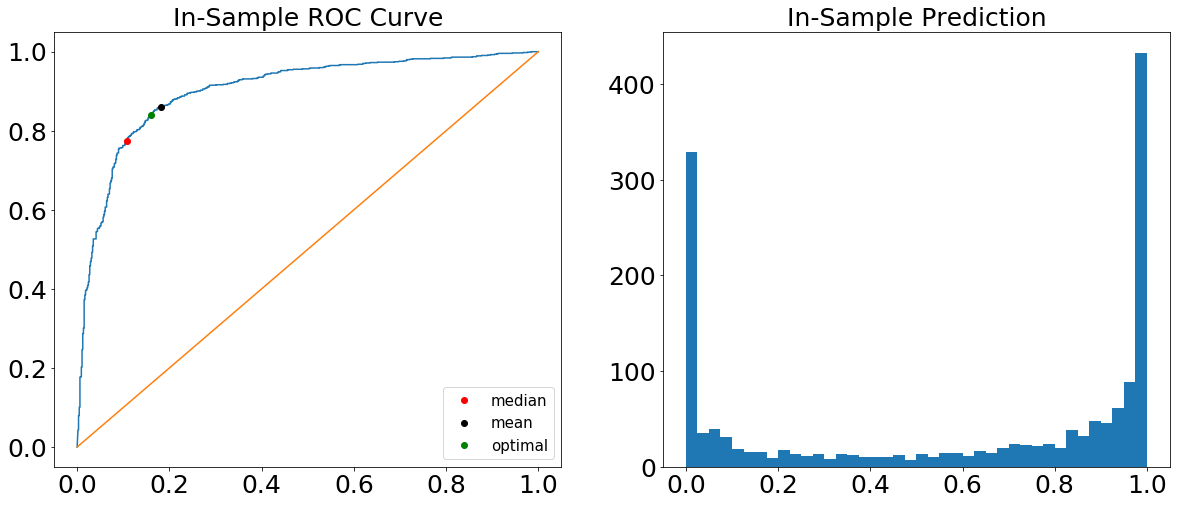

In [35]:
#######################################################
####
#### in-sample ROC curve to determine trading signal
####
#######################################################


y_score = model.predict(X_train.T).ravel()
fpr, tpr, threshold = roc_curve(y_train, y_score)

#### median, mean and optimal points on ROC curve
ind_med = np.argmin(np.abs(threshold-np.median(y_score)))
ind_mean = np.argmin(np.abs(threshold-np.mean(y_score)))
ind_opt = np.argmin(np.abs(tpr - (1-fpr) ))


fig, axs = plt.subplots( 1, 2, figsize = ( 20, 8 ) )
axs[0].plot(fpr,tpr)
axs[0].plot(fpr,fpr);
axs[ 0].tick_params( axis = 'both', which = 'major', labelsize = 25 )
axs[0].plot(fpr[ind_med],tpr[ind_med],'ro',label='median') 
axs[0].plot(fpr[ind_mean],tpr[ind_mean],'ko',label='mean'); 
axs[0].plot(fpr[ind_opt],tpr[ind_opt],'go',label='optimal'); 
axs[0].legend(loc="lower right",fontsize = 15)
axs[0].set_title('In-Sample ROC Curve',fontsize = 25);


axs[1].hist(y_score,40);
axs[1].set_title('In-Sample Prediction',fontsize = 25);
axs[1].tick_params( axis = 'both', which = 'major', labelsize = 25 )
plt.savefig( '../lecture18/NNROC_train_1000x4x2000.eps', format = 'eps', bbox_inches = 'tight' )

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


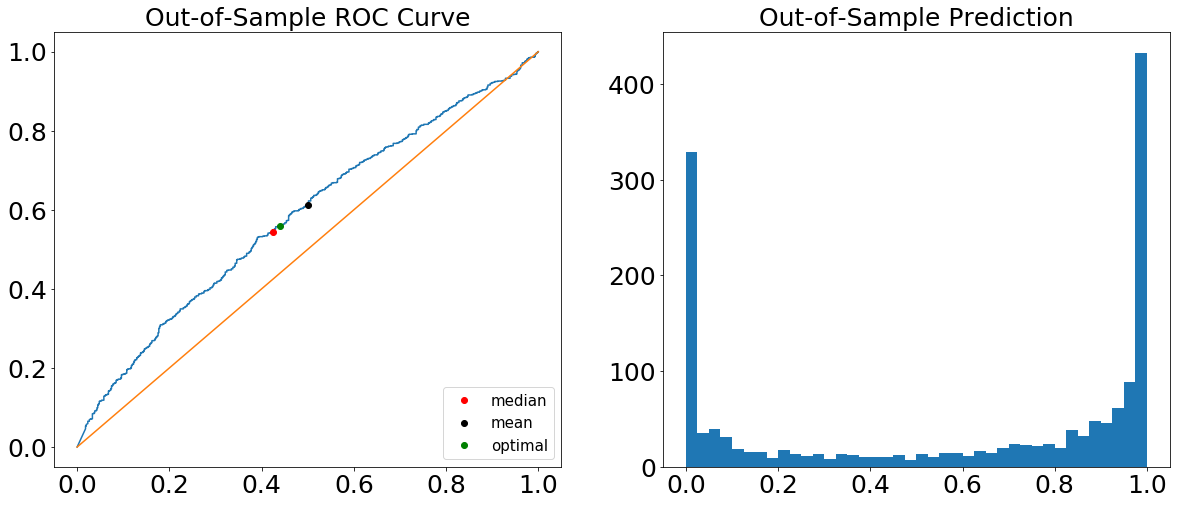

In [37]:
#######################################################
####
#### out-of-sample ROC curve
####
#######################################################


y_score_test = model.predict(X_test.T).ravel()
fpr, tpr, threshold = roc_curve(y_test, y_score_test)

#### median, mean and optimal points on ROC curve
ind_med = np.argmin(np.abs(threshold-np.median(y_score_test)))
ind_mean = np.argmin(np.abs(threshold-np.mean(y_score_test)))
ind_opt_test = np.argmin(np.abs(tpr - (1-fpr) ))


fig, axs = plt.subplots( 1, 2, figsize = ( 20, 8 ) )
axs[0].plot(fpr,tpr)
axs[0].plot(fpr,fpr);
axs[ 0].tick_params( axis = 'both', which = 'major', labelsize = 25 )
axs[0].plot(fpr[ind_med],tpr[ind_med],'ro',label='median') 
axs[0].plot(fpr[ind_mean],tpr[ind_mean],'ko',label='mean'); 
axs[0].plot(fpr[ind_opt_test],tpr[ind_opt_test],'go',label='optimal'); 
axs[0].legend(loc="lower right",fontsize = 15)
axs[0].set_title('Out-of-Sample ROC Curve',fontsize = 25);


axs[1].hist(y_score,40);
axs[1].set_title('Out-of-Sample Prediction',fontsize = 25);
axs[1].tick_params( axis = 'both', which = 'major', labelsize = 25 )
plt.savefig( '../lecture18/NNROC_test_1000x4x2000.eps', format = 'eps', bbox_inches = 'tight' )

/usr/local/Cellar/jupyterlab/1.2.3/libexec/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


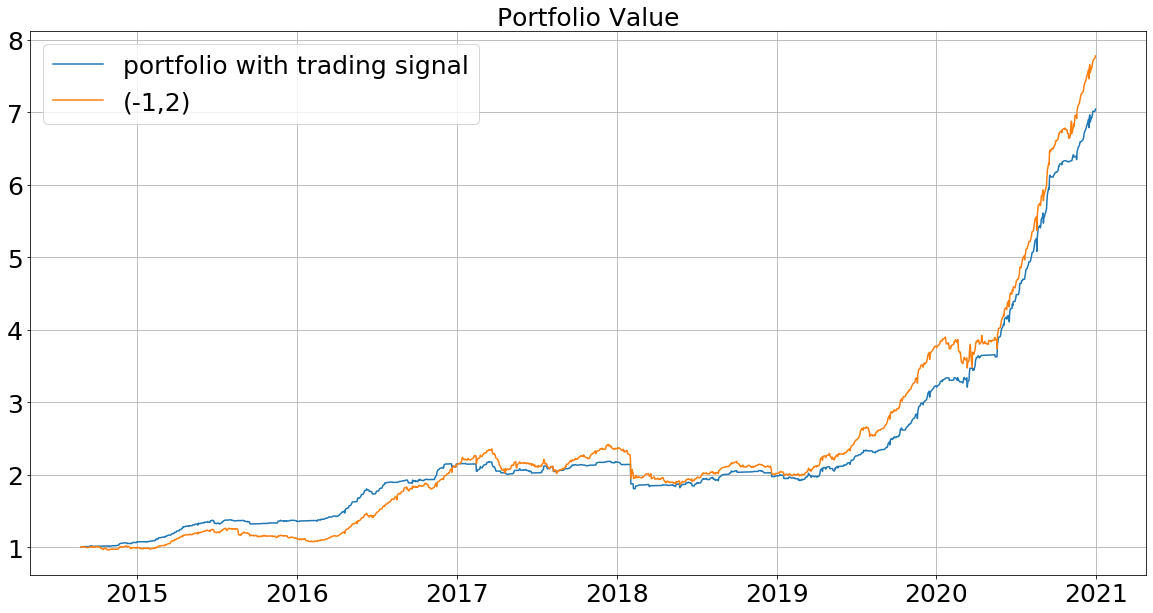

In [9]:
#######################################################
####
#### out-of-sample portfolio using trading signal
####
#######################################################

my_cutoff = threshold[ind_opt]   #### this is trading signal 

y_score = model.predict(X_test.T).ravel()
my_predict = (np.sign(y_score-my_cutoff)+1)/2

r_my_trade = my_predict*(r_trade[ind_test]) +(1-my_predict)*r*dt
p_my_trade = np.exp(np.cumsum(np.log(1+r_my_trade)))
p_trade = np.exp(np.cumsum(np.log(1+r_trade[ind_test])))

plt.figure( figsize = ( 20, 10 ) )
plt.plot(dates[ind_test],p_my_trade, label="portfolio with trading signal");
plt.plot(dates[ind_test],p_trade, label="(-1,2)");
plt.title('Portfolio Value', fontsize = 25 )
plt.xticks( fontsize = 25 );
plt.yticks( fontsize = 25 )
plt.legend(loc="upper left",fontsize = 25)
plt.grid( which = 'major' )
plt.grid( which = 'minor', linestyle = ':' )
plt.savefig( '../lecture18/NNSignal1000x4x1000.eps', format = 'eps', bbox_inches = 'tight' );



No handles with labels found to put in legend.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


my return rate:  0.3074959751804048
(-1,2) return rate:  0.323084094815226


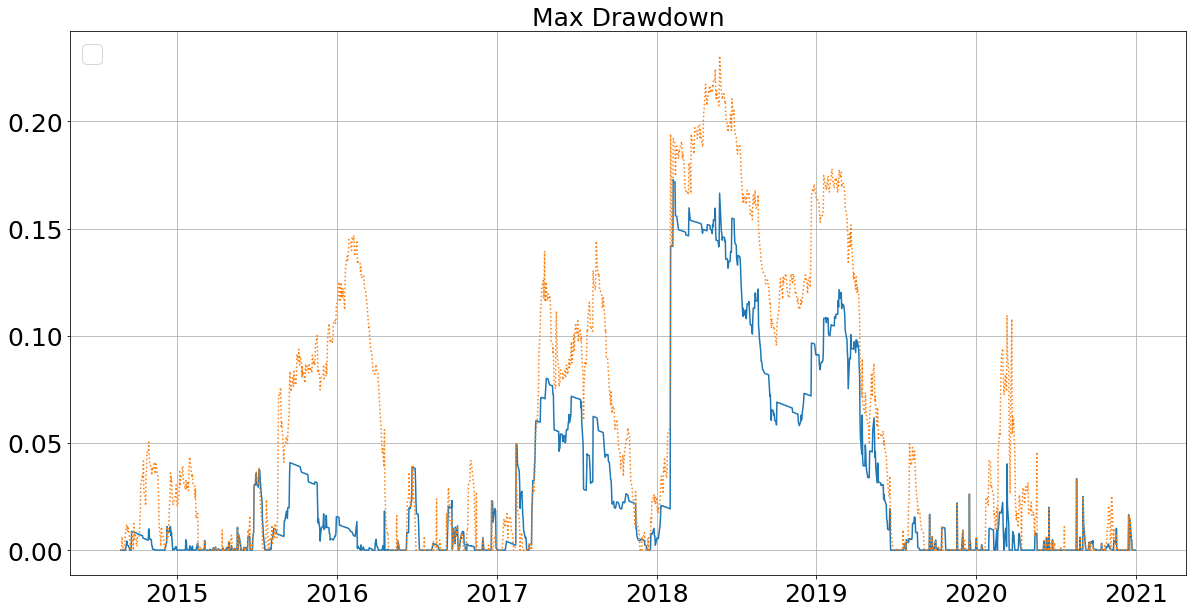

In [10]:
#######################################################
####
#### out-of-sample portfolio return rates and max drawdowns
####
#######################################################

print('my return rate: ',np.log(p_my_trade[-1])/(len(ind_test)*dt))
print('(-1,2) return rate: ',np.log(p_trade[-1])/(len(ind_test)*dt))

p_my_trade_discount = p_my_trade*np.exp(-r*dt*np.arange(len(ind_test)))
p_trade_discount = p_trade*np.exp(-r*dt*np.arange(len(ind_test)))
                                        
my_dd = 1-p_my_trade_discount/np.maximum.accumulate(p_my_trade_discount)
dd = 1-p_trade_discount/np.maximum.accumulate(p_trade_discount)

plt.figure( figsize = ( 20, 10 ) )
plt.plot(dates[ind_test],my_dd)
plt.plot(dates[ind_test],dd,':');
plt.title('Max Drawdown', fontsize = 25);
plt.xticks( fontsize = 25 );
plt.yticks( fontsize = 25 )
plt.legend(loc="upper left",fontsize = 25)
plt.grid( which = 'major' )
plt.grid( which = 'minor', linestyle = ':' )
plt.savefig( '../lecture18/NNSignal1000x6x2000_maxDD.eps', format = 'eps', bbox_inches = 'tight' );



In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 11)                0         
_________________________________________________________________
dense (Dense)                (None, 1000)              12000     
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1001      
Total params: 3,016,001
Trainable params: 3,016,001
Non-trainable params: 0
______________________________________________

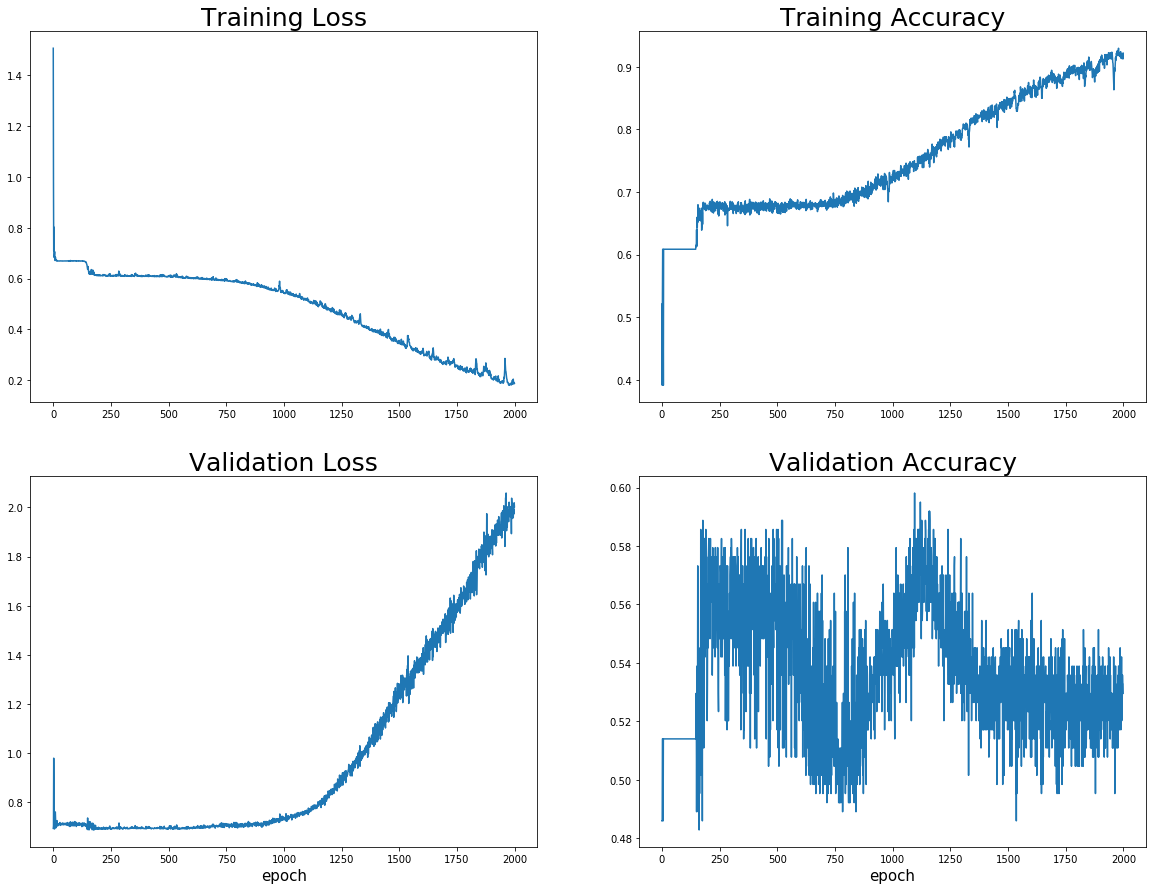

In [38]:
fig, axs = plt.subplots( 2, 2, figsize = ( 20, 15 ) )
axs[0,0].plot(model_history.history['loss'])
axs[0,0].set_title('Training Loss',fontsize = 25);
axs[0, 0].tick_params( axis = 'both', which = 'major', labelsize = 15 )

axs[0,1].plot(model_history.history['accuracy'])
axs[0,1].set_title('Training Accuracy',fontsize = 25);
axs[0, 1].tick_params( axis = 'both', which = 'major', labelsize = 15 )

axs[1,0].plot(model_history.history['val_loss'])
axs[1,0].set_title('Validation Loss',fontsize = 25);
axs[1,0].set_xlabel('epoch',fontsize = 15)
axs[1, 0].tick_params( axis = 'both', which = 'major', labelsize = 15 )

axs[1,1].plot(model_history.history['val_accuracy'])
axs[1,1].set_title('Validation Accuracy',fontsize = 25);
axs[1,1].set_xlabel('epoch',fontsize = 15);
axs[1, 1].tick_params( axis = 'both', which = 'major', labelsize = 15 )

plt.savefig( '../lecture18/NNSignal1000x4x2000_diagnostics.eps', format = 'eps', bbox_inches = 'tight' );
